In [1]:
import json
import os
import random
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, log_loss, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.class_weight import compute_class_weight

pd.options.mode.chained_assignment = None

with open("../data/feature-meta/cleaned/meta.json") as f:
    feature_meta = json.load(f)

feature_meta

{'customerID': {'is_raw': True, 'type': 'ID'},
 'gender': {'is_raw': True, 'var_type': 'boolean', 'value_type': 'text'},
 'SeniorCitizen': {'is_raw': True,
  'var_type': 'boolean',
  'value_type': 'numeric'},
 'Partner': {'is_raw': True, 'var_type': 'boolean', 'value_type': 'text'},
 'Dependents': {'is_raw': True, 'var_type': 'boolean', 'value_type': 'text'},
 'tenure': {'is_raw': True, 'var_type': 'real', 'value_type': 'numeric'},
 'PhoneService': {'is_raw': True, 'var_type': 'boolean', 'value_type': 'text'},
 'MultipleLines': {'is_raw': True,
  'var_type': 'categorical',
  'value_type': 'text'},
 'InternetService': {'is_raw': True,
  'var_type': 'categorical',
  'value_type': 'text'},
 'OnlineSecurity': {'is_raw': True,
  'var_type': 'categorical',
  'value_type': 'text'},
 'OnlineBackup': {'is_raw': True,
  'var_type': 'categorical',
  'value_type': 'text'},
 'DeviceProtection': {'is_raw': True,
  'var_type': 'categorical',
  'value_type': 'text'},
 'TechSupport': {'is_raw': True,
 

In [2]:
x_train = pd.read_parquet("../data/featurized/x_train/data.parquet")
x_test = pd.read_parquet("../data/featurized/x_test/data.parquet")

In [3]:
y_train = pd.read_parquet("../data/featurized/y_train/data.parquet")
y_test = pd.read_parquet("../data/featurized/y_test/data.parquet")

In [4]:
x_train, x_cv, y_train, y_cv = train_test_split(
    x_train, y_train, test_size=0.2, shuffle=False
)

In [5]:
x_train.shape, x_cv.shape, x_test.shape

((4507, 34), (1127, 34), (1409, 34))

In [6]:
x_train.columns

Index(['PaymentMethod_0', 'PaymentMethod_1', 'PaymentMethod_2', 'Contract_0',
       'Contract_1', 'StreamingTV_0', 'StreamingTV_1', 'TechSupport_0',
       'TechSupport_1', 'DeviceProtection_0', 'DeviceProtection_1',
       'OnlineBackup_0', 'OnlineBackup_1', 'OnlineSecurity_0',
       'OnlineSecurity_1', 'InternetService_0', 'InternetService_1',
       'MultipleLines_0', 'MultipleLines_1', 'customerID', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'sin_hour',
       'cos_hour', 'sin_day', 'cos_day', 'sin_month', 'cos_month'],
      dtype='object')

In [7]:
x_train.drop(columns=["customerID"], inplace=True)
x_cv.drop(columns=["customerID"], inplace=True)
x_test.drop(columns=["customerID"], inplace=True)

# Performing feature selection using feature importance

1. Using random forest model for getting feature importance

In [8]:
n_estimators_list = [10, 20, 30, 40, 100, 200, 250, 300, 350, 500, 600]

errors_log = []
for ne in n_estimators_list:
    print(f"{'-'*30} n_estimators={ne} {'-'*30}")

    clf = RandomForestRegressor(n_estimators=ne,)
    clf = clf.fit(x_train, y_train["tenure"])

    # get log los train
    y_pred_train = clf.predict(x_train)
    mse_train = mean_squared_error(y_train["tenure"], y_pred_train)

    # get log los cv set
    y_pred_val = clf.predict(x_cv)
    mse_val = mean_squared_error(y_cv["tenure"], y_pred_val)

    # append logs to dictionary

    obj = {
        "n_estimators": ne,
        "mse_train": mse_train,
        "mse_cv": mse_val,
    }
    errors_log.append(obj)

    print(f"mse train {obj['mse_train']:.4f}")
    print(f"mse cv {obj['mse_cv']:.4f}")

------------------------------ n_estimators=10 ------------------------------
mse train 1.0140
mse cv 2.1569
------------------------------ n_estimators=20 ------------------------------
mse train 0.7798
mse cv 2.2441
------------------------------ n_estimators=30 ------------------------------
mse train 0.7933
mse cv 1.9358
------------------------------ n_estimators=40 ------------------------------
mse train 0.5314
mse cv 1.9052
------------------------------ n_estimators=100 ------------------------------
mse train 0.5272
mse cv 1.8410
------------------------------ n_estimators=200 ------------------------------
mse train 0.5842
mse cv 1.8482
------------------------------ n_estimators=250 ------------------------------
mse train 0.5365
mse cv 1.8352
------------------------------ n_estimators=300 ------------------------------
mse train 0.5097
mse cv 1.8145
------------------------------ n_estimators=350 ------------------------------
mse train 0.6173
mse cv 1.7967
--------------

In [9]:
l = []
for i in errors_log:
    l.append([i["n_estimators"], i["mse_train"], i["mse_cv"]])
l = np.array(l)
l

array([[1.00000000e+01, 1.01397160e+00, 2.15685892e+00],
       [2.00000000e+01, 7.79755381e-01, 2.24411047e+00],
       [3.00000000e+01, 7.93265538e-01, 1.93578231e+00],
       [4.00000000e+01, 5.31363989e-01, 1.90515694e+00],
       [1.00000000e+02, 5.27206501e-01, 1.84096992e+00],
       [2.00000000e+02, 5.84171217e-01, 1.84821826e+00],
       [2.50000000e+02, 5.36454539e-01, 1.83516566e+00],
       [3.00000000e+02, 5.09743917e-01, 1.81449894e+00],
       [3.50000000e+02, 6.17288990e-01, 1.79671248e+00],
       [5.00000000e+02, 5.50037771e-01, 1.79286949e+00],
       [6.00000000e+02, 5.56356828e-01, 1.79525036e+00]])

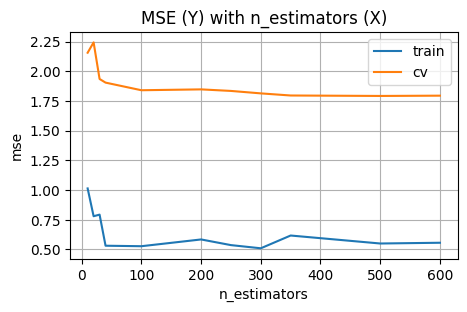

In [10]:
plt.figure(figsize=[5, 3], dpi=100)
plt.title("MSE (Y) with n_estimators (X)")
plt.plot(l[:, 0], l[:, 1])
plt.plot(l[:, 0], l[:, 2])

plt.ylabel("mse")
plt.xlabel("n_estimators")
plt.grid()
plt.legend(["train", "cv"])
plt.show()

We can see at n_estimators = 200 we are getting a decent reduction in cross validation loss, using it as an optimal parameter


# refit with best model to get feature importance

In [11]:
clf = RandomForestRegressor(n_estimators=200,)
clf = clf.fit(x_train, y_train["tenure"])

In [12]:
df_fimp = pd.DataFrame([x_train.columns, clf.feature_importances_]).T.rename(
    columns={0: "feature", 1: "importance"}
)
df_fimp = df_fimp.sort_values(by=["importance"], ascending=False,).reset_index(
    drop=True
)

In [13]:
# top 5 features
df_fimp.head()

,feature,importance
0,TotalCharges,0.826223
1,MonthlyCharges,0.153425
2,Contract_0,0.0107563
3,Contract_1,0.00423764
4,InternetService_1,0.000822816


We can see that TotalCharges and MonthlyCharges are showing high feature importance in regression task.

In [14]:
# bottom 5 features
df_fimp.tail()

,feature,importance
28,OnlineSecurity_1,4.55717e-05
29,DeviceProtection_0,4.05158e-05
30,SeniorCitizen,3.47289e-05
31,OnlineBackup_1,3.28731e-05
32,StreamingTV_0,3.17372e-05


Binary features are showing relatively less feature importance as compared to real features

Plot of feature importances using Randomforest regressor for regression task

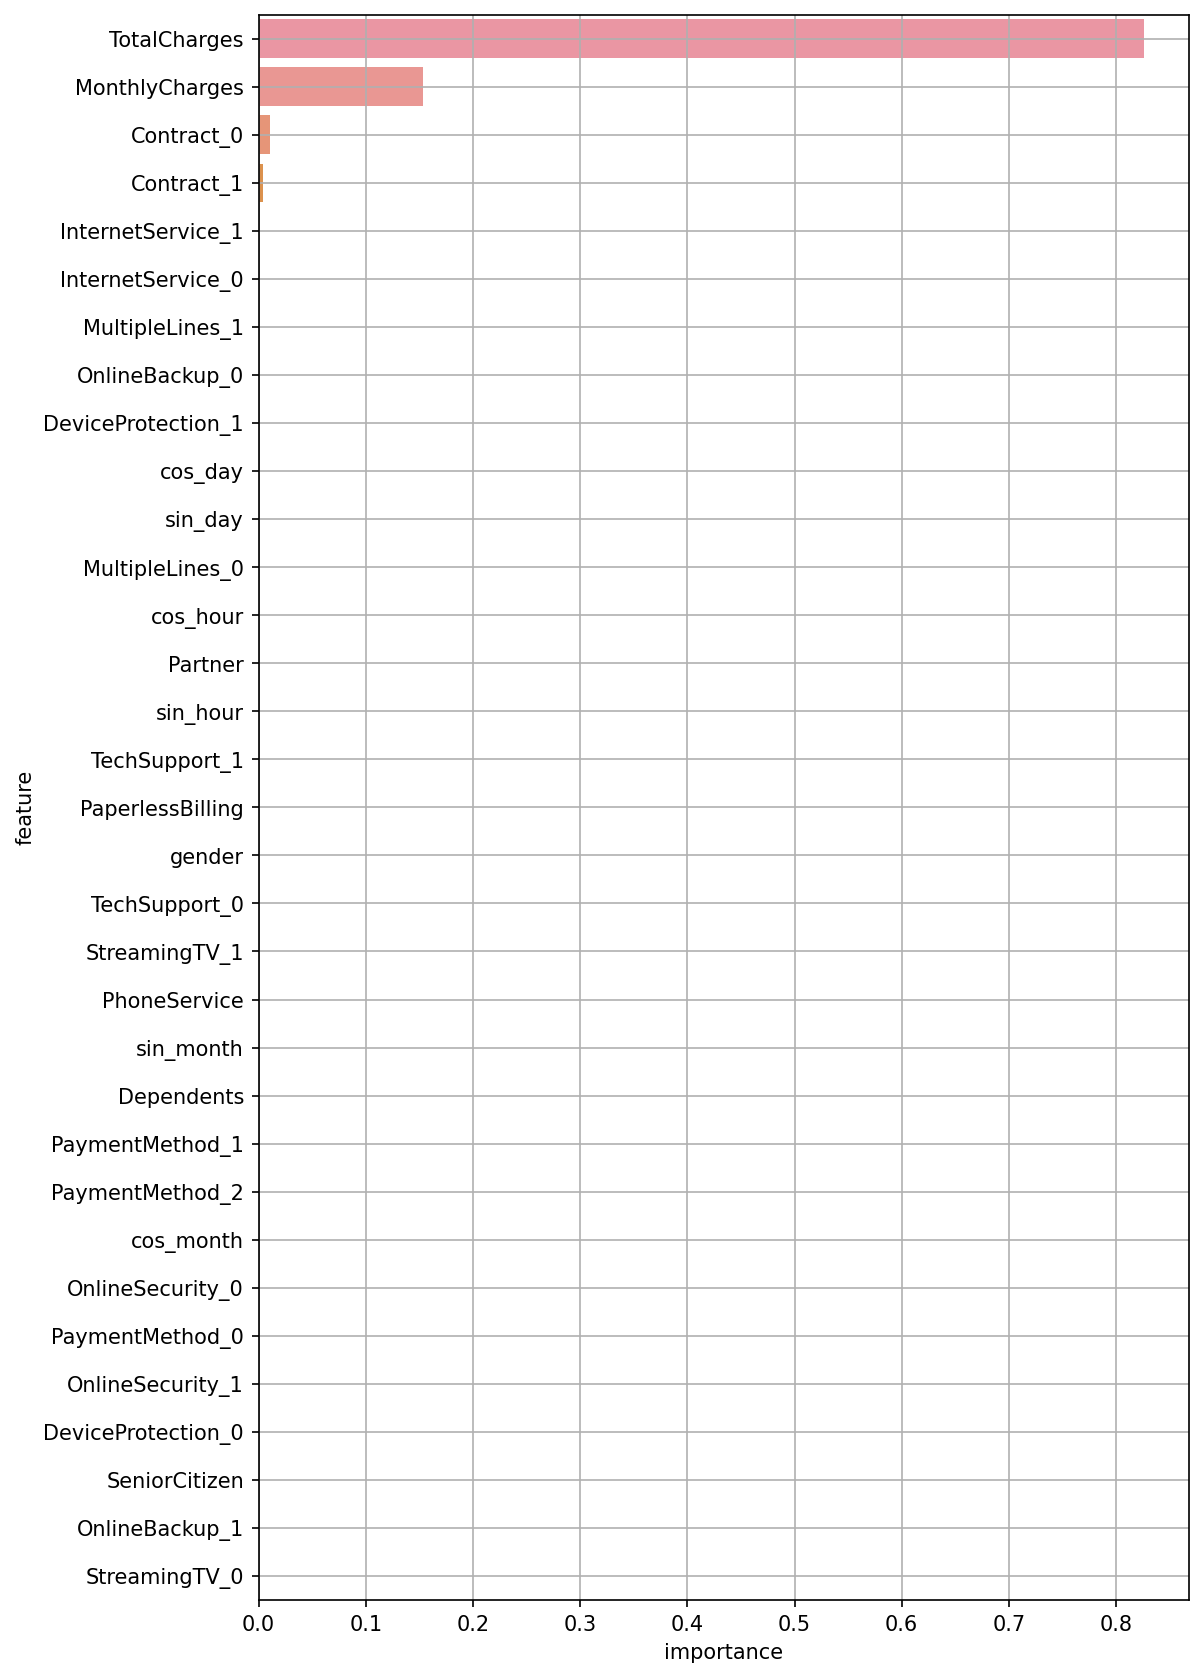

In [15]:
plt.figure(figsize=[8, 14], dpi=150)
sns.barplot(y="feature", x="importance", data=df_fimp.head(50))
plt.grid()
plt.show()

# selecting features

As mentioned in the problem statement selecting top 6 features

In [16]:
selected_features = df_fimp[:6]["feature"].values
selected_features

array(['TotalCharges', 'MonthlyCharges', 'Contract_0', 'Contract_1',
       'InternetService_1', 'InternetService_0'], dtype=object)

In [17]:
os.makedirs("../data/selected_features_regression/x_train", exist_ok=True)
os.makedirs("../data/selected_features_regression/x_cv", exist_ok=True)
os.makedirs("../data/selected_features_regression/x_test", exist_ok=True)

os.makedirs("../data/selected_features_regression/y_train", exist_ok=True)
os.makedirs("../data/selected_features_regression/y_cv", exist_ok=True)
os.makedirs("../data/selected_features_regression/y_test", exist_ok=True)

In [18]:
x_train[selected_features].to_parquet(
    "../data/selected_features_regression/x_train/data.parquet"
)
x_cv[selected_features].to_parquet(
    "../data/selected_features_regression/x_cv/data.parquet"
)
x_test[selected_features].to_parquet(
    "../data/selected_features_regression/x_test/data.parquet"
)

In [19]:
y_train.to_parquet("../data/selected_features_regression/y_train/data.parquet")
y_cv.to_parquet("../data/selected_features_regression/y_cv/data.parquet")
y_test.to_parquet("../data/selected_features_regression/y_test/data.parquet")